In [1]:
## Increase the model dimensions to 192
## using multiple heads  (2)
## also increments upto 100

## Train with random sequences generated

In [2]:
## Standard libraries
import os
import numpy as np
import random
import math
import json
from functools import partial
import inspect

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()

## tqdm for loading bars
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as nnF
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision import transforms
from tqdm import tqdm


# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "Sequence_task_pytorch"


# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.determinstic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

#inflect package - number2words

/var/folders/rm/yd2zfw9x2lqgqd8nz8qb3x300000gn/T/ipykernel_8784/1003232331.py:15: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Device: cpu


In [3]:
# Setting the seed
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything()

In [4]:
print(torch.__version__)

1.10.1


In [5]:
def subsequent_mask(size, batch =1):
    "Mask out subsequent positions."
    attn_shape = (batch, 1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

In [6]:
def scaled_dot_product(q, k, v, mask=None):
    d_k = q.size()[-1]
    attn_logits = torch.matmul(q, k.transpose(-2, -1))
    attn_logits = attn_logits / math.sqrt(d_k)
    if mask is not None:
        attn_logits = attn_logits.masked_fill(mask == 0, -9e15)
    attention = nnF.softmax(attn_logits, dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [7]:
class MultiheadAttention(nn.Module):

    def __init__(self, input_dim, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "Embedding dimension must be 0 modulo number of heads."

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Stack all weight matrices 1...h together for efficiency
        # Note that in many implementations you see "bias=False" which is optional
        self.qkv_proj = nn.Linear(input_dim, 3*embed_dim)
        self.o_proj = nn.Linear(embed_dim, embed_dim)

        self._reset_parameters()

    def _reset_parameters(self):
        # Original Transformer initialization, see PyTorch documentation
        nn.init.xavier_uniform_(self.qkv_proj.weight)
        self.qkv_proj.bias.data.fill_(0)
        nn.init.xavier_uniform_(self.o_proj.weight)
        self.o_proj.bias.data.fill_(0)

    def forward(self, x, mask=None, return_attention=False, return_v=False):
        batch_size, seq_length, embed_dim = x.size()
        qkv = self.qkv_proj(x)

        # Separate Q, K, V from linear output
        qkv = qkv.reshape(batch_size, seq_length, self.num_heads, 3*self.head_dim)
        qkv = qkv.permute(0, 2, 1, 3) # [Batch, Head, SeqLen, Dims]
        q, k, v = qkv.chunk(3, dim=-1)

        # Determine value outputs
        values, attention = scaled_dot_product(q, k, v, mask=mask)
        values = values.permute(0, 2, 1, 3) # [Batch, SeqLen, Head, Dims]
        values = values.reshape(batch_size, seq_length, embed_dim)
        o = self.o_proj(values)

        if return_attention:
            if return_v:
                return o,attention,v, self.o_proj.weight, self.o_proj.bias
            else:
                return o, attention 
        else:
            return o

In [8]:
class EncoderBlock(nn.Module):

    def __init__(self, input_dim, num_heads, dim_feedforward, dropout=0.0):
        """
        Inputs:
            input_dim - Dimensionality of the input
            num_heads - Number of heads to use in the attention block
            dim_feedforward - Dimensionality of the hidden layer in the MLP
            dropout - Dropout probability to use in the dropout layers
        """
        super().__init__()

        # Attention layer
        self.self_attn = MultiheadAttention(input_dim, input_dim, num_heads)

        # Two-layer MLP
        self.linear_net = nn.Sequential(
            nn.Linear(input_dim, dim_feedforward),
            nn.Dropout(dropout),
            nn.ReLU(inplace=True),
            nn.Linear(dim_feedforward, input_dim)
        )

        # Layers to apply in between the main layers
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        # Attention part
        attn_out = self.self_attn(x, mask=mask)
        x = x + self.dropout(attn_out)
        x = self.norm1(x)

        # MLP part
        linear_out = self.linear_net(x)
        x = x + self.dropout(linear_out)
        x = self.norm2(x)

        return x

In [9]:
class TransformerEncoder(nn.Module):

    def __init__(self, num_layers, **block_args):
        super().__init__()
        self.layers = nn.ModuleList([EncoderBlock(**block_args) for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for l in self.layers:
            x = l(x, mask=mask)
        return x

    def get_attention_maps(self, x, mask=None):
        attention_maps = []
        for l in self.layers:
            _, attn_map = l.self_attn(x, mask=mask, return_attention=True)
            attention_maps.append(attn_map)
            x = l(x, mask=mask)
        return attention_maps
    
    def get_norm_maps(self, x, mask=None):
        norm_maps = []
        for l in self.layers:
            _, attn_map, v,W_o, b_o = l.self_attn(x, mask=mask, return_attention=True, return_v=True)
            print(W_o.shape, b_o.shape)
            norm_map = torch.linalg.norm( torch.einsum('ijkl,ijlm->ijklm',attn_map,v), axis = -1)
            print(norm_map.size)
            norm_maps.append(norm_map)
            x = l(x, mask=mask)
        return norm_maps

In [10]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model, max_len=5000):
        """
        Inputs
            d_model - Hidden dimensionality of the input.
            max_len - Maximum length of a sequence to expect.
        """
        super().__init__()

        # Create matrix of [SeqLen, HiddenDim] representing the positional encoding for max_len inputs
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)

        # register_buffer => Tensor which is not a parameter, but should be part of the modules state.
        # Used for tensors that need to be on the same device as the module.
        # persistent=False tells PyTorch to not add the buffer to the state dict (e.g. when we save the model)
        self.register_buffer('pe', pe, persistent=False)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return x

In [11]:
class CosineWarmupScheduler(optim.lr_scheduler._LRScheduler):

    def __init__(self, optimizer, warmup, max_iters):
        self.warmup = warmup
        self.max_num_iters = max_iters
        super().__init__(optimizer)

    def get_lr(self):
        lr_factor = self.get_lr_factor(epoch=self.last_epoch)
        return [base_lr * lr_factor for base_lr in self.base_lrs]

    def get_lr_factor(self, epoch):
        lr_factor = 0.5 * (1 + np.cos(np.pi * epoch / self.max_num_iters))
        if epoch <= self.warmup:
            lr_factor *= epoch * 1.0 / self.warmup
        return lr_factor

In [12]:
class Transformer(nn.Module):

    def __init__(self, input_dim, model_dim, num_classes, num_heads, num_layers, dropout=0.0, input_dropout=0.0):
        """
        Inputs:
            input_dim - Hidden dimensionality of the input
            model_dim - Hidden dimensionality to use inside the Transformer
            num_classes - Number of classes to predict per sequence element
            num_heads - Number of heads to use in the Multi-Head Attention blocks
            num_layers - Number of encoder blocks to use.
            dropout - Dropout to apply inside the model
            input_dropout - Dropout to apply on the input features
        """
        super(Transformer, self).__init__()
        for item in inspect.signature(Transformer).parameters:
            setattr(self, item, eval(item))
        
        # Input dim -> Model dim
        self.input_net = nn.Sequential(
            nn.Dropout(input_dropout),
            nn.Linear(input_dim, model_dim)
        )
        # Positional encoding for sequences
        self.positional_encoding = PositionalEncoding(d_model=model_dim)
        # Transformer
        self.transformer = TransformerEncoder(num_layers=num_layers,
                                              input_dim=model_dim,
                                              dim_feedforward=2*model_dim,
                                              num_heads=num_heads,
                                              dropout=dropout)
        # Output classifier per sequence element
        self.output_net = nn.Sequential(
            nn.Linear(model_dim, model_dim),
            nn.LayerNorm(model_dim),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Linear(model_dim, num_classes)
        )

    def forward(self, x, mask=None, add_positional_encoding=True):
        """
        Inputs:
            x - Input features of shape [Batch, SeqLen, input_dim]
            mask - Mask to apply on the attention outputs (optional)
            add_positional_encoding - If True, we add the positional encoding to the input.
                                      Might not be desired for some tasks.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        x = self.transformer(x, mask=mask)
        x = self.output_net(x)
                
        return x

    def get_attention_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the attention matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        attention_maps = self.transformer.get_attention_maps(x, mask=mask)
        return attention_maps
    
    def get_norm_maps(self, x, mask=None, add_positional_encoding=True):
        """
        Function for extracting the norm matrices of the whole Transformer for a single batch.
        Input arguments same as the forward pass.
        """
        x = self.input_net(x)
        if add_positional_encoding:
            x = self.positional_encoding(x)
        norm_maps = self.transformer.get_norm_maps(x, mask=mask)
        return norm_maps


## Dataset

In [13]:
class sequenceDataset(data.Dataset):

    def __init__(self, num_categories, seq_len, size= 1000000):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len
        #self.size = size
        
        self.data = torch.from_numpy(np.array([np.sort(np.random.choice(np.arange(1,10000), 10, replace=False, p= (1/9999)*np.ones(9999) )) for i in np.arange(size)]))

    def __len__(self):
        return self.data.size()[0]

    def __getitem__(self, idx):
        inp_data = self.data[idx]
                        
        # predict the next number (adding 1)
        change = inp_data - np.roll(inp_data,1 )
        change[0] = 0 
        labels = inp_data + change
        
        return inp_data, labels

In [14]:
seq_len = 10
n_cat = 10000
full_dataset = sequenceDataset(n_cat , seq_len)
print(len(full_dataset))

train_size = int(0.7 * len(full_dataset))
val_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset)-train_size -val_size
batch = 512
print(train_size, val_size, test_size)
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size,val_size, test_size])

train_loader = data.DataLoader(train_dataset, batch_size=batch, shuffle=True, drop_last=True, pin_memory=True)
val_loader   = data.DataLoader(val_dataset, batch_size=batch)
test_loader  = data.DataLoader(test_dataset, batch_size=batch)



1000000
700000 100000 200000


In [15]:
## Sample input--output

inp_data, labels = train_loader.dataset[0]
print("Input data:", inp_data)
print("Labels:    ", labels)
print(torch.abs(labels-inp_data))

Input data: tensor([1868, 2658, 3481, 3701, 3863, 6139, 6368, 6730, 7186, 8949])
Labels:     tensor([ 1868,  3448,  4304,  3921,  4025,  8415,  6597,  7092,  7642, 10712])
tensor([   0,  790,  823,  220,  162, 2276,  229,  362,  456, 1763])


(array([4.325189e+06, 1.628360e+06, 6.748320e+05, 2.538380e+05,
        8.514600e+04, 2.474800e+04, 5.726000e+03, 1.031000e+03,
        1.650000e+02, 5.000000e+00]),
 array([   0. ,  821.7, 1643.4, 2465.1, 3286.8, 4108.5, 4930.2, 5751.9,
        6573.6, 7395.3, 8217. ]),
 <BarContainer object of 10 artists>)

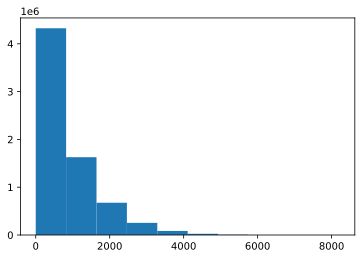

In [16]:
## Distribution of change in Training data

ch = np.zeros(int(train_size/batch)*batch*seq_len)

for i,(data, labels) in enumerate(train_loader):
    ch[i*seq_len*batch :(i+1)*seq_len*batch ] = np.abs(labels.view(-1)- data.view(-1))

plt.hist(ch)

(array([5.81255e+05, 2.35243e+05, 1.09064e+05, 4.67790e+04, 1.84510e+04,
        6.56500e+03, 2.00100e+03, 5.08000e+02, 1.20000e+02, 1.40000e+01]),
 array([   0. ,  735.9, 1471.8, 2207.7, 2943.6, 3679.5, 4415.4, 5151.3,
        5887.2, 6623.1, 7359. ]),
 <BarContainer object of 10 artists>)

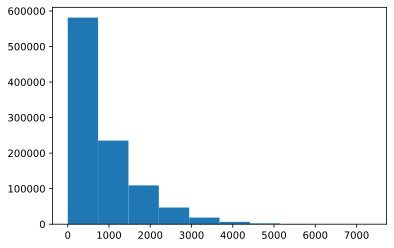

In [17]:
## Distribution of change in Validation data

ch = np.zeros(val_size*seq_len)

for i,(data, labels) in enumerate(val_loader):
    ch[i*seq_len*batch :(i+1)*seq_len*batch  ] = np.abs(labels.view(-1)- data.view(-1))

plt.hist(ch)

(array([1.197187e+06, 4.686710e+05, 2.062870e+05, 8.382000e+04,
        3.070500e+04, 9.846000e+03, 2.775000e+03, 6.020000e+02,
        1.020000e+02, 5.000000e+00]),
 array([   0. ,  775.4, 1550.8, 2326.2, 3101.6, 3877. , 4652.4, 5427.8,
        6203.2, 6978.6, 7754. ]),
 <BarContainer object of 10 artists>)

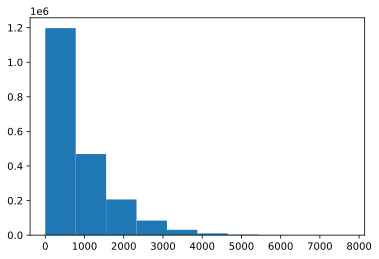

In [18]:
## Distribution of change in Validation data

ch = np.zeros(test_size*seq_len)

for i,(data, labels) in enumerate(test_loader):
    ch[i*seq_len*batch :(i+1)*seq_len*batch  ] = np.abs(labels.view(-1)- data.view(-1))

plt.hist(ch)

## Training 

In [19]:
## Model params

input_dim=full_dataset.num_categories*2
model_dim= 192    ### increased from 32
num_heads= 2        ##increased from 1
num_classes=full_dataset.num_categories*2
num_layers=1      
dropout=0.0
lr=5e-4
warmup=50
max_epochs = 200
max_iters= max_epochs*len(train_loader)

## Training with validation
model = Transformer(input_dim, model_dim, num_classes, num_heads, num_layers,dropout)
model = model.to(device)

## Initializing optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# Apply lr scheduler per step
lr_scheduler = CosineWarmupScheduler(optimizer,
                                     warmup=warmup,
                                     max_iters=max_iters)


In [20]:
## Training with validation 

def calculate_loss(data, labels, model):
    seq_len = labels.size()[1]
    data = nnF.one_hot(data, num_classes= num_classes).float()
    target= model.forward(data, mask = subsequent_mask(data.size(-2),data.size(0)).to(device),add_positional_encoding=True)

    target_ = target.view(-1,target.size(-1))
    labels_ = labels.view(-1)
    
    loss = nnF.cross_entropy(target_, labels_ ) 
    
    return loss, target

def training(model, train_loader, val_loader,epochs,num_classes):
    
    # start with pretrained weights
    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'saved_model_upd_dataset.pth')
    if os.path.isfile(pretrained_filename):
        checkpoint = torch.load(pretrained_filename)
        model.load_state_dict(checkpoint['model_state_dict'])
    
    # Early stopping
    patience = 10
    trigger_times = 0
    min_val_loss = np.inf
    for epoch in tqdm(range(epochs)):
        train_loss = 0.0
        model.train()     
        for i,(data, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            if torch.cuda.is_available():
                data, labels = data.to(device), labels.to(device)
            loss,_ = calculate_loss(data, labels, model)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            train_loss += loss.item()

        val_loss = 0.0
        model.eval()    
        for data, labels in val_loader:
            if torch.cuda.is_available():
                data, labels = data.to(device), labels.to(device)
            loss,_ = calculate_loss(data, labels, model)
            # Calculate Loss
            val_loss += loss.item()

        print(f'Epoch {epoch+1} \t\t Training Loss: {train_loss / len(train_loader)} \t\t Validation Loss: {val_loss / len(val_loader)}')
        
        
        if min_val_loss > val_loss:
            print('trigger times: 0')
            trigger_times = 0
            print(f'Validation Loss Decreased({min_val_loss:.6f}--->{val_loss:.6f}) \t Saving The Model')
            min_val_loss = val_loss
            # Saving State Dict
            os.makedirs(CHECKPOINT_PATH, exist_ok=True)
            pretrained_filename = os.path.join(CHECKPOINT_PATH,'saved_model_upd_dataset_final.pth')
            torch.save({
                'epoch': epoch+1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_loss': val_loss,
                }, pretrained_filename)  
        '''   
        else:
            trigger_times += 1
            print('trigger times:', trigger_times)

            if trigger_times >= patience:
                print('Early stopping!\n')
                return model
        ''' 
            
            
    return model


    

In [21]:
print(model)

Transformer(
  (input_net): Sequential(
    (0): Dropout(p=0.0, inplace=False)
    (1): Linear(in_features=20000, out_features=192, bias=True)
  )
  (positional_encoding): PositionalEncoding()
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0): EncoderBlock(
        (self_attn): MultiheadAttention(
          (qkv_proj): Linear(in_features=192, out_features=576, bias=True)
          (o_proj): Linear(in_features=192, out_features=192, bias=True)
        )
        (linear_net): Sequential(
          (0): Linear(in_features=192, out_features=384, bias=True)
          (1): Dropout(p=0.0, inplace=False)
          (2): ReLU(inplace=True)
          (3): Linear(in_features=384, out_features=192, bias=True)
        )
        (norm1): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((192,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (output_net): Sequential(
    (0): Linear(in_featu

In [ ]:
# Check whether pretrained model exists. If yes, load it and skip training
pretrained_filename = os.path.join(CHECKPOINT_PATH, 'saved_model_upd_dataset_final.pth')
if os.path.isfile(pretrained_filename):
    print("Found pretrained model, loading...")
    checkpoint = torch.load(pretrained_filename)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch = checkpoint['epoch']
    val_loss = checkpoint['val_loss']
else:
    model = training(model, train_loader, val_loader,max_epochs,num_classes)

  0%|                                                | 0/200 [01:37<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
def test(model, test_loader):
    model.eval()
    test_loss = 0.0
    test_acc = 0.0
    with torch.no_grad():
        for i,(data, labels) in tqdm(enumerate(test_loader)):
            if torch.cuda.is_available():
                data, labels = data.to(device), labels.to(device)        
            loss, target = calculate_loss(data, labels, model)
            test_loss += loss.item()

            acc = (target.argmax(dim=-1) == labels).float().mean()
            test_acc += acc

        print("Loss:", test_loss / len(test_loader),"\n","Accuracy:", 100*(test_acc.item() / len(test_loader)))

In [ ]:
print(epoch)

In [ ]:
print("Train-set: ")
test(model, train_loader)
print("Val-set: ")
test(model, val_loader)

## Testing

In [ ]:
print("Test-set: ")
test(model, test_loader) 

In [ ]:
data_input_test, labels_test = next(iter(test_loader))
inp_data_test = nnF.one_hot(data_input_test[:,:], num_classes=num_classes).float()
inp_data_test = inp_data_test.to(device)

pred_output =model.forward(inp_data_test,  mask = subsequent_mask(inp_data_test.size(-2),inp_data_test.size(0)).to(device))
_, output_test = torch.max(pred_output, dim =-1)
print(output_test)


In [ ]:
index = np.arange(10,20)
print(data_input_test[index,:])
print(output_test[index,:] )

## Creating attention maps

In [ ]:
def plot_attention_maps(input_data, attn_maps, idx=0):
    if input_data is not None:
        input_data = input_data[idx].detach().cpu().numpy()
    else:
        input_data =self.log('train_loss', loss) 
    attn_maps = [m[idx].detach().cpu().numpy() for m in attn_maps]

    num_heads = attn_maps[0].shape[0]
    num_layers = len(attn_maps)
    seq_len = input_data.shape[0]
    fig_size = 4 if num_heads == 1 else 3
    fig, ax = plt.subplots(num_layers, num_heads, figsize=(num_heads*fig_size, num_layers*fig_size))
    if num_layers == 1:
        ax = [ax]
    if num_heads == 1:
        ax = [[a] for a in ax]
    
    for row in range(num_layers):
        for column in range(num_heads):
            #print(attn_maps[row][column])
            ax[row][column].imshow(attn_maps[row][column], origin='upper', vmin=0)
            ax[row][column].set_xticks(list(range(seq_len)))
            ax[row][column].set_xticklabels(input_data.tolist())
            ax[row][column].set_yticks(list(range(seq_len)))
            ax[row][column].set_yticklabels(input_data.tolist())
            ax[row][column].set_title(f"Layer {row+1}, Head {column+1}")
            # Rotate the tick labels and set their alignment.
            plt.setp(ax[row][column].get_xticklabels(), rotation=45, ha="right",
                     rotation_mode="anchor")
    fig.subplots_adjust(hspace=0.5)
    plt.show()

In [ ]:
data_input, labels = next(iter(val_loader))
inp_data = nnF.one_hot(data_input, num_classes=num_classes).float()
inp_data = inp_data.to(device)
attention_maps = model.get_attention_maps(inp_data,mask = subsequent_mask(inp_data.size(-2),inp_data.size(0)).to(device))
norm_maps = model.get_norm_maps(inp_data,mask = subsequent_mask(inp_data.size(-2),inp_data.size(0)).to(device))

In [ ]:
print(attention_maps[0].shape)
print(norm_maps[0].shape)

In [ ]:
plot_attention_maps(data_input, attention_maps, idx=0)

## Random test

In [ ]:
#data_input_test = torch.tensor([[1, 3000, 5, 7]])
#data_input_test = torch.randint(0, 9999,(13,)).unsqueeze(0)
#data_input_test = torch.from_numpy(np.arange(1,15)).unsqueeze(0)

#data_input_test = torch.from_numpy(np.arange(4018,3090 ,-101)).unsqueeze(0)
data_input_test = torch.from_numpy(np.arange(1,1100, 110)).unsqueeze(0)
print(data_input_test)
inp_data_test = nnF.one_hot(data_input_test[:,:], num_classes=num_classes).float()
inp_data_test = inp_data_test.to(device)

pred_output =model.forward(inp_data_test,  mask = subsequent_mask(inp_data_test.size(-2),inp_data_test.size(0)).to(device))
_, output_test = torch.max(pred_output, dim =-1)


print(output_test)


In [ ]:
attention_maps_test = model.get_attention_maps(inp_data_test,mask = subsequent_mask(inp_data_test.size(-2),inp_data_test.size(0)).to(device))
plot_attention_maps(data_input_test, attention_maps_test, idx=0)

In [ ]:
import torch.utils.data as data
class taskDataset(data.Dataset):
    
    def __init__(self, num_categories, seq_len):
        super().__init__()
        self.num_categories = num_categories
        self.seq_len = seq_len


        self.data = torch.from_numpy(np.array([np.arange(sv, sv+(self.seq_len*step), step) for step in np.arange(1,1000) for sv in np.arange(1,self.num_categories-(self.seq_len),1) if sv+(self.seq_len*step)< self.num_categories]))

    def __len__(self):
        return self.data.size()[0]

    def __getitem__(self, idx):
        inp_data = self.data[idx]

        
        # predict the next number (adding 1)
        change = inp_data - np.roll(inp_data,1 )
        change[0] = 0 
        labels = inp_data + change
        
        return inp_data, labels

In [ ]:
task_test_dataset = taskDataset(10000, 10)
print(len(task_test_dataset))

task_test_loader  = data.DataLoader(task_test_dataset, batch_size=512)

In [ ]:
## Sample input--output

inp_data, labels = task_test_loader.dataset[2222]
print("Input data:", inp_data)
print("Labels:    ", labels)



In [ ]:
print(" Task Test-set: ")
test(model, task_test_loader) 

In [ ]:
## Sample random test output

data_input_test, labels_test = next(iter(task_test_loader))
inp_data_test = nnF.one_hot(data_input_test[:,:], num_classes=num_classes).float()
inp_data_test = inp_data_test.to(device)

pred_output =model.forward(inp_data_test,  mask = subsequent_mask(inp_data_test.size(-2),inp_data_test.size(0)).to(device))
_, output_test = torch.max(pred_output, dim =-1)


index = np.arange(200, 210)
print(data_input_test[index,:])
print(output_test[index,:] )


In [ ]:
## Error Analysis

model.eval()
total_error_rows = 0
change =[]
with torch.no_grad():
    for i,(data, labels) in tqdm(enumerate(task_test_loader)):
        if torch.cuda.is_available():
            data, labels = data.to(device), labels.to(device)   
        loss, target = calculate_loss(data, labels, model)
        acc = (target.argmax(dim=-1) == labels)
        total_error_rows += np.unique(np.where(acc.cpu()==0)[0]).shape[0]
        change.append(np.array((data[np.unique(np.where(acc.cpu()==0)[0])][:,1] -data[np.unique(np.where(acc.cpu()==0)[0])][:,0]).cpu()))
        
change = np.concatenate(change, axis=0 )
print(change.shape)
print(total_error_rows)

In [ ]:
plt.hist(change)

## Model parameters

In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

## Checking the layers 

In [ ]:
def get_activations(inp, model, layers= [4]):
    
    inp_layers = nn.ModuleList(list(model.input_net)). eval()
    pe_layer = model.positional_encoding
    trf_layers = nn.ModuleList(list(model.transformer.layers)). eval()
    out_layers= nn.ModuleList(list(model.output_net)). eval()
    
    send_outs ={}

    for i, layer in enumerate(inp_layers ):
        inp = layer(inp)
    
    inp = pe_layer(inp)
    
    for i, layer in enumerate(trf_layers ):
        inp =layer(inp, mask = subsequent_mask(inp.size(-2),inp.size(0)).to(device))
        
    
    for i, layer in enumerate(out_layers):
        inp = layer(inp)
        if i in layers:
            out = inp.cpu().detach().numpy()
            send_outs[i] = out.squeeze()

    return send_outs

In [ ]:
def get_embeddings(inp, model, layers= [1]):
    
    inp_layers = nn.ModuleList(list(model.input_net)). eval()
    pe_layer = model.positional_encoding
    trf_layers = nn.ModuleList(list(model.transformer.layers)). eval()
    out_layers= nn.ModuleList(list(model.output_net)). eval()
    
    send_outs ={}

    for i, layer in enumerate(inp_layers ):
        inp = layer(inp)
    
    out = inp.cpu().detach().numpy()
    send_outs[i] = out.squeeze()
    
    return send_outs

## Input embeddings

In [ ]:
from scipy import spatial
data_input = torch.from_numpy(np.arange(1,10000)).unsqueeze(0)
inp_data = nnF.one_hot(data_input, num_classes=num_classes).float()
inp_data = inp_data.to(device)
print(data_input)

outs = get_embeddings(inp_data, model)
print(outs[1].shape)
max_index = 10000-1

if os.path.isfile(os.path.join(CHECKPOINT_PATH, 'dist_matrix_updated_dataset.npz')):
    dist_matrix = np.load(os.path.join(CHECKPOINT_PATH, 'dist_matrix_updated_dataset.npz'))['dist_matrix']   
else:
    dist_matrix = np.zeros((max_index,max_index))
    for i in tqdm(np.arange(max_index)):
        for j in np.arange(i,max_index):
            dist_matrix[i,j] = spatial.distance.cosine(outs[1][i,:], outs[1][j,:])
    np.savez(os.path.join(CHECKPOINT_PATH, 'dist_matrix_updated_dataset.npz'), dist_matrix= dist_matrix)
        
#plt.imshow(dist_matrix)
#print(dist_matrix)
dist_matrix_new = dist_matrix + dist_matrix.T

In [ ]:
from scipy import fftpack
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

M, N = dist_matrix_new.shape
F = fftpack.fftn(dist_matrix_new)
F_magnitude = np.abs(F)
F_magnitude = fftpack.fftshift(F_magnitude)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(4.8*2, 4.8*2))
im = ax0.imshow(np.log10(1 + F_magnitude), cmap='viridis',extent=(-N // 2, N // 2, -M // 2, M // 2))
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')
ax0.set_title('Spectrum magnitude');


im =ax1.imshow(dist_matrix_new, extent=(1,9999,9999,1))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')
ax1.set_title('Cosine distance between Embeddings');

plt.show()

In [ ]:
from scipy import spatial
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
%matplotlib notebook


max_index = 10000-1
if os.path.isfile(os.path.join(CHECKPOINT_PATH, 'dist_matrix_updated_dataset.npz')):
    dist_matrix = np.load(os.path.join(CHECKPOINT_PATH, 'dist_matrix_updated_dataset.npz'))['dist_matrix']   
else:
    dist_matrix = np.zeros((max_index,max_index))
    for i in tqdm(np.arange(max_index)):
        for j in np.arange(i,max_index):
            dist_matrix[i,j] = spatial.distance.cosine(outs[1][i,:], outs[1][j,:])
    np.savez(os.path.join(CHECKPOINT_PATH, 'dist_matrix_updated_dataset.npz'), dist_matrix= dist_matrix)
        
#plt.imshow(dist_matrix)
#print(dist_matrix)
dist_matrix_new = dist_matrix + dist_matrix.T


fig = plt.figure()
ax = fig.gca(projection='3d')

nx, ny = dist_matrix_new.shape
x ,y = np.arange(1,nx+1), np.arange(1,ny+1)
X, Y = np.meshgrid(x, y)  # `plot_surface` expects `x` and `y` data to be 2D

# Plot the surface.
surf = ax.plot_surface(X, Y, dist_matrix_new, cmap=cm.coolwarm, linewidth=0, antialiased=False)
# Customize the z axis.
ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))
# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

In [ ]:
## distances on number line

from scipy import spatial
from  functools import reduce


if os.path.isfile(os.path.join(CHECKPOINT_PATH, 'dist_matrix_numbers.npz')):
    dist_matrix_numbers = np.load(os.path.join(CHECKPOINT_PATH, 'dist_matrix_numbers.npz'))['dist_matrix_number']   
else:
    size = max_index
    vals = np.arange(size)
    res = reduce(lambda a, b: a+np.eye(size,k=b[0])*b[1], enumerate(vals), np.zeros((size, size)))
    np.savez(os.path.join(CHECKPOINT_PATH, 'dist_matrix_numbers.npz'), dist_matrix_number= res)
        
#print(dist_matrix)
dist_matrix_num = (dist_matrix_numbers + dist_matrix_numbers.T)/max_index 
#plt.imshow(dist_matrix_num)

In [ ]:
from scipy import fftpack

M, N = dist_matrix_num.shape
F = fftpack.fftn(dist_matrix_num)
F_magnitude = np.abs(F)
F_magnitude = fftpack.fftshift(F_magnitude)

f, (ax0, ax1) = plt.subplots(1, 2, figsize=(4.8*2, 4.8*2))
im = ax0.imshow(np.log10(1 + F_magnitude), cmap='viridis',extent=(-N // 2, N // 2, -M // 2, M // 2))
divider = make_axes_locatable(ax0)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')
ax0.set_title('Spectrum magnitude');


im =ax1.imshow(dist_matrix_num, extent=(1,9999,9999,1))
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="5%", pad=0.05)
f.colorbar(im, cax=cax, orientation='vertical')
ax1.set_title('Distance Matrix for numbers');

plt.show()